### Build Reproducible Experiments
In this notebook, the aim is to show you how to build a reproducible experiment within Azure. In this example, we're going to train a MNIST classifier using Tensorflow and show you how you can follow some practices to make this work reproducible. Later you can use this framework and apply it to other ML problems.

The reason we chose MNIST is to pick a very simple example as the main focus is to build a reproducible experiment and not to learn a new algorithm or to build a complex model.

**Important Note:**:

In order to practice all parts of the following Notebook, you first need to get a free Azure credit. If you don't have it, you can simply obtain it through this link: https://azure.microsoft.com/en-us/free/

You can run this notebook on your local latop, Azure Notebooks (notebooks.azure.com) or Notebook VMs:
- Local Laptop - the following packages has to be installed:
    - Azureml-SDK - with notebook,widget extensions
    - tensorflow==1.13
- Azure Notebooks:
    - This is a free notebook, all of the packages for an ML experiment is installed
- AzureML Notebook:
    - This is a premium notebook that you can choose the VM type. Avoid using this feature for the workshop as you may burn your credit before the end or the workshop.

Once you chose the execution environment, you need to create an Azure Machine Learning Service. Follow this instruction to build one:

The following text is copied from: https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-1st-experiment-sdk-setup#create-a-workspace


An Azure Machine Learning workspace is a foundational resource in the cloud that you use to experiment, train, and deploy machine learning models. It ties your Azure subscription and resource group to an easily consumed object in the service.

You create a workspace via the Azure portal, a web-based console for managing your Azure resources.

1. Sign in to the Azure portal by using the credentials for the Azure subscription you use.
1. In the upper-left corner of Azure portal, select + Create a resource.
1. Create a new resource
1. Use the search bar to find Machine Learning service workspace.
1. Select Machine Learning service workspace.
1. In the Machine Learning service workspace pane, select Create to begin.
1. Provide the following information to configure your new workspace:
    - **Field	Description**
    - **Workspace name**: type in **FirstExample**.
    - **Subscription**: Select the Azure subscription that you want to use. (Your free credit)
    - **Resource group**: type in **MLOpsWorkshop**
    - **Location**: type in **westus2**
1. After you are finished configuring the workspace, select Create.
When the process is finished, a deployment success message appears.
1. To view the new workspace, select Go to resource.


You can explore the resource from two view:
1. https://portal.azure.com (you can access all resources including Azure ML)
1. https://ml.azure.com (recently released - still in preview and dedicated to Azure ML)

First we download the MNIST sample files from Yann Lecun website to our development environment:

In [18]:
import os
import urllib

os.makedirs('./data/mnist', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename = './data/mnist/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename = './data/mnist/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename = './data/mnist/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename = './data/mnist/test-labels.gz')


('./data/mnist/test-labels.gz', <http.client.HTTPMessage at 0x227a9c41308>)

Import a bunch of packages.

In [21]:
%matplotlib inline
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt


Import the AzureML SDK package to be able to communicate with Azure ML Services

In [3]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)


SDK version: 1.0.65


In [1]:
# Your subscription ID will be different replace the stirng with yours
subscription_id = "<subscription_id>"
resource_group = "MLOpsWorkshop"
workspace_name = "FirstExample"
workspace_region = "westus2"

Initiate an object from Workspace class. the Workspace object will point to the created Workspace we created through the portal

In [2]:
# import the Workspace class and check the azureml SDK version
# exist_ok checks if workspace exists or not.

from azureml.core import Workspace

ws = Workspace(workspace_name = workspace_name,
               subscription_id = subscription_id,
               resource_group = resource_group)

# persist the subscription id, resource group name, and workspace name in aml_config/config.json.
ws.write_config()

In [3]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')


Workspace name: FirstExample
Azure region: westus2
Subscription id: ed70929a-e125-4daf-8945-04f709d2c75e
Resource group: MLOpsWorkshop


### Start a new Experiment

In software engineering world we have a new feature to develop. In ML/Data Science world, we work on experiments.

**Experiments** represent the collection of trials used to validate a user's hypothesis. We call each trial a run.

Here we create a new experiment, we want to make sure everything related to this experiment is saved within the workspace and the lineage between each artifact is preserved.

In [4]:
from azureml.core import Experiment

exp = Experiment(workspace=ws, name='tracking-logs')

### 1. Track and Log Metrics

We have two ways to start a trail (Run). Interactively and through batch submite. The start_loggin() method is the interactive way of starting a trail. It returns a Run object that we can use to log important metrics or the trail.

The key metrics can a single value for the accuracy of an ML model, a list of values representing the distribution or the data or an image showing the confusion matrix.

In [6]:
# Initializing log tracking action by creating a Run object in the Experiment
run =  exp.start_logging()

In [7]:
run.get_status()

'Running'

Here you see that the **azureml.git.repository_uri** is poinint to the remote repo and the **azureml.git.branch** property is poining to the active branch.

In [8]:
run.get_details()

{'runId': '19043492-f61a-4d4b-ae1b-044d4e478082',
 'target': 'sdk',
 'status': 'Running',
 'startTimeUtc': '2019-10-16T20:46:13.46428Z',
 'properties': {'azureml.git.repository_uri': 'https://github.com/classicboyir/exp-repro.git',
  'mlflow.source.git.repoURL': 'https://github.com/classicboyir/exp-repro.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': 'ad924179738fbf1cdbc68752c5e0121c74df1c9b',
  'mlflow.source.git.commit': 'ad924179738fbf1cdbc68752c5e0121c74df1c9b',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': 'c6e2b072-2458-4e31-af43-77c130631562'},
 'inputDatasets': [],
 'logFiles': {}}

**RunDetails** class helps you visualize the active run object. It creates a network connection with Azure ML Worspace to collect everything happening during the run. It gets updated every 15 seconds.

In [9]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

**logs** function will log a single-valued or multi-valued metric under the current RUN. There are several types of logs, metric, table, row, image, etc.

Every time you add a new metric, check the widget above:

In [10]:
run.log('metric_1', 1.1)

In [11]:
run.log('metric_1', 2.0)

In [12]:
run.log('metric_1', 2.0)

In [23]:
run.log('metric_1', 4.0)

In [24]:
run.log('metric_1', 4.0)

In [25]:
run.log('metric_1', 2.5)

In [33]:
run.log('metric_1', 6.3)

In [19]:
# Log some metrics about the input dataset:
    
from utils import load_data

# Unzipping the input dataset and conver the data points into Numpy arrays
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

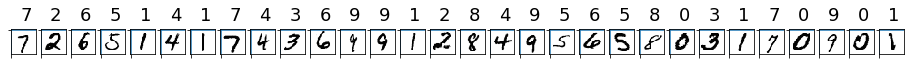

In [22]:
# Record how the input dataset looks like
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
    
run.log_image(name='{}-samples-of-input-dataset'.format(sample_size), plot=plt)

In [ ]:
import pandas as pd
dist = pd.DataFrame(data=y_train, columns=['test_values'])['test_values'].value_counts()

run.log_table('digit_dist', {"count":list(dist.values), "digits":list(dist.index)})

In [ ]:
X_train.shape

In [ ]:
run.log('train_dataset_size', X_train.shape[0])

In [ ]:
run.log('test_dataset_size', X_test.shape[0])

## 2. Data and Datasets

As an important part of experiment reproducibility, you'd like to separate your dataset from the training code and the development environment. There are two major ways that you can achieve this. First you can use datastores to define the connection to an Azure data store such as Blob, SQL or Databricks table, then you leverage Datasets to access the actual files and version the reference to those file assets.

### 2.1 Generate data references for the ML job

Once an ML Workspace is created, a storage account is created with a default container (a logical container that works as a folder - this is refered to as bucket in AWS S3). The container is attached to the Workspace automatically as the default storage account. You can find it as **workspaceblobstore** under Datastores (https://ml.azure.com). This storage account can be used for test and development but should not be used in production scenarios. Because if you decide to delete the Workspace, the default storage account is also deleted which results in losing your data. So it's wiser to create a separate storage account and attach it to the ML Workspace.

Here is how to access the default storage account:

In [31]:
# get_default_datastore returns the default datastore attached to the Workspace
ds = ws.get_default_datastore()

ds.name

'workspaceblobstore'

As the name of the default datastore suggestion, it's a reference to a Blob storage. Blob storage is a general purpose data lake that can be used to store any type of binary, from image, to csv file. Here are other types of Azure Storage types that you can attach to the WorkSpace:

- Azure File Share
- Azure Data Lake
- Azure Data Lake Gen2
- Azure SQL Database
- Azure PostgreSQL
- Databricks File System

The following is an example of registering (attaching) a new Blob storage account:

In [36]:
# from azureml.core.datastore import Datastore
# blob_datastore = Datastore.register_azure_blob_container(
#            workspace=ws,
#            datastore_name='<datastore_name>',
#            account_name='<account_name>', # Storage account name
#            container_name='<container_name>', # Name of Azure blob container
#            account_key='<account_key>')

Let's upload the files that I downloaded to this storage for longer retention. This datastore can be referenced later in my training job.

In [43]:
ds.upload(src_dir='./data/mnist', target_path='mnist', overwrite=True, show_progress=True)

Uploading an estimated of 4 files
Uploading ./data/mnist\test-images.gz
Uploading ./data/mnist\test-labels.gz
Uploading ./data/mnist\train-images.gz
Uploading ./data/mnist\train-labels.gz
Uploaded ./data/mnist\test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/mnist\train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/mnist\test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/mnist\train-images.gz, 4 files out of an estimated total of 4
Uploaded 4 files


$AZUREML_DATAREFERENCE_036fd2f51eb84b0f9b07a1604563e049

### 2.2 Generate Datasets

There are two different types of Datasets, TabularDataset and FileDataset. The Tabular can be used to access tabular like datasources, such as csv, SQL, Databricks, etc which FileDatasets can be used for binary datasets such as image, audio, etc. The following is a way to define a tabular dataset from an online source.

In [49]:
from azureml.core.dataset import Dataset

# create a TabularDataset from a delimited file behind a public web url
web_path ='https://dprepdata.blob.core.windows.net/demo/Titanic.csv'
titanic_ds = Dataset.Tabular.from_delimited_files(path=web_path)

# To convert the Dataset into Spark (you need to have Spark installed on your development environment)
# titanic_ds.take(3).to_spark_dataframe()

# preview the first 3 rows of titanic_ds
titanic_ds.take(3).to_pandas_dataframe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S


Datasets are references to a datasource (registered under datasources or available over internet). In other words, they don't keep the data, they are the reference definitiosn. You can register the defined Datasets under the Datasets section (accessible through ml.azure.com). Each time you register the dataset under the same name, you'll get a new version generated. Later you can access a particular version for the registered Dataset. As the dataset doesn't store your data, if you remove or change the data, the Dataset object doesn't help you roll back the change. Therefore, it's recommended to keep the data untouched. 

In order to keep the actual dataset, you can copy the data (using Azure Data Factory SDK or AzCopy CLI tool or [Azure SDK](https://github.com/Azure/azure-sdk-for-python/tree/master/sdk/storage/azure-storage-blob)) to clone the data to a new blob location and keep the under a new Dataset object.

In the following cells, I've generated two versions of the Dataset. Every version of the titanic_ds can have different reference structure.

In [41]:
titanic_ds = titanic_ds.register(workspace = ws,
                                 name = 'titanic_ds',
                                 description = 'titanic training data',
                                 create_new_version = True)

In [44]:
titanic_ds = titanic_ds.register(workspace = ws,
                                 name = 'titanic_ds',
                                 description = 'titanic training data',
                                 create_new_version = True)

At any time you can retrive a particular version of Dataset:

In [46]:
titanic_ds_v1 = Dataset.get_by_name(workspace = ws,
                                 name = 'titanic_ds', 
                                 version = 1)

titanic_ds_v1.take(3).to_pandas_dataframe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S


In [50]:
# # Sample code to access Parquet files: link: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-create-register-datasets
#     
# # create a TabularDataset with time series trait
# datastore_paths = [(datastore, 'weather/*/*/*/data.parquet')]
# 
# # get a coarse timestamp column from the path pattern
# dataset = Dataset.Tabular.from_parquet_files(path=datastore_path, partition_format='weather/{coarse_time:yyy/MM/dd}/data.parquet')
# 
# # set coarse timestamp to the virtual column created, and fine grain timestamp from a column in the data
# dataset = dataset.with_timestamp_columns(fine_grain_timestamp='datetime', coarse_grain_timestamp='coarse_time')
# 
# # filter with time-series-trait-specific methods
# data_slice = dataset.time_before(datetime(2019, 1, 1))
# data_slice = dataset.time_after(datetime(2019, 1, 1))
# data_slice = dataset.time_between(datetime(2019, 1, 1), datetime(2019, 2, 1))
# data_slice = dataset.time_recent(timedelta(weeks=1, days=1))

Now going back to our MNIST problem, let's create a Dataset object from the file uploaded to the default Datastore and register the Dataset:

In [61]:
datastore_paths = [(ds, 'mnist/test-images.gz'),
 (ds, 'mnist/test-labels.gz'),
 (ds, 'mnist/train-images.gz'),
 (ds, 'mnist/train-labels.gz')]

mnist_dataset = Dataset.File.from_files(datastore_paths)
mnist_dataset

{
  "source": [
    "('workspaceblobstore', 'mnist/test-images.gz')",
    "('workspaceblobstore', 'mnist/test-labels.gz')",
    "('workspaceblobstore', 'mnist/train-images.gz')",
    "('workspaceblobstore', 'mnist/train-labels.gz')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

Now let's register it within the Datasets:

In [62]:
mnist_dataset.register(workspace = ws,
                                 name = 'mnist_dataset',
                                 description = 'MNIST input dataset',
                                 create_new_version = True)

{
  "source": [
    "('workspaceblobstore', 'mnist/test-images.gz')",
    "('workspaceblobstore', 'mnist/test-labels.gz')",
    "('workspaceblobstore', 'mnist/train-images.gz')",
    "('workspaceblobstore', 'mnist/train-labels.gz')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "name": "mnist_dataset",
    "version": 1,
    "description": "MNIST input dataset",
    "workspace": "Workspace.create(name='FirstExample', subscription_id='ed70929a-e125-4daf-8945-04f709d2c75e', resource_group='MLOpsWorkshop')"
  }
}

You define a new Dataset under **mnist_dataset** by accessing the actual file over the internet:

In [63]:
web_paths = [
            'http://lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
            ]

mnist_dataset_web = Dataset.File.from_files(path = web_paths)

mnist_dataset_web.register(workspace = ws,
                                 name = 'mnist_dataset',
                                 description = 'MNIST input dataset',
                                 create_new_version = True)

{
  "source": [
    "http://lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
    "http://lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
    "http://lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
    "http://lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
  ],
  "definition": [
    "GetFiles"
  ],
  "registration": {
    "name": "mnist_dataset",
    "version": 2,
    "description": "MNIST input dataset",
    "workspace": "Workspace.create(name='FirstExample', subscription_id='ed70929a-e125-4daf-8945-04f709d2c75e', resource_group='MLOpsWorkshop')"
  }
}

In [64]:
mnist_dataset_v1 = Dataset.get_by_name(workspace = ws,
                                 name = 'mnist_dataset', 
                                 version = 1)

In [87]:
# get the list of registered files back
mnist_dataset_v1.to_path()

array(['/workspaceblobstore/mnist/test-images.gz',
       '/workspaceblobstore/mnist/test-labels.gz',
       '/workspaceblobstore/mnist/train-images.gz',
       '/workspaceblobstore/mnist/train-labels.gz'], dtype=object)

To increase the level of flexibility, I create a different dataset for each file:

In [90]:
datastore_path_test_images = [(ds, 'mnist/test-images.gz')]
datastore_path_test_labels = [(ds, 'mnist/test-labels.gz')]
datastore_path_train_images = [(ds, 'mnist/train-images.gz')]
datastore_path_train_labels = [(ds, 'mnist/train-labels.gz')]

dataset_test_images = Dataset.File.from_files(datastore_path_test_images)
dataset_test_images.register(workspace=ws, name='mnist_test_images', description='MNIST input dataset for test images', create_new_version = True)

dataset_test_labels = Dataset.File.from_files(datastore_path_test_labels)
dataset_test_labels.register(workspace=ws, name='mnist_test_labels', description='MNIST input dataset for test labels', create_new_version = True)

dataset_train_images = Dataset.File.from_files(datastore_path_train_images)
dataset_train_images.register(workspace=ws, name='mnist_train_images', description='MNIST input dataset for train images', create_new_version = True)

dataset_train_labels = Dataset.File.from_files(datastore_path_train_labels)
dataset_train_labels.register(workspace=ws, name='mnist_train_labels', description='MNIST input dataset for train labels', create_new_version = True)


{
  "source": [
    "('workspaceblobstore', 'mnist/train-labels.gz')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "name": "mnist_train_labels",
    "version": 1,
    "description": "MNIST input dataset for train labels",
    "workspace": "Workspace.create(name='FirstExample', subscription_id='ed70929a-e125-4daf-8945-04f709d2c75e', resource_group='MLOpsWorkshop')"
  }
}

In [88]:
Dataset.File.from_files

In [59]:
!git commit -m "added datasets and versioned them"

[master c68a6c8] added datasets and versioned them
 3 files changed, 722 insertions(+), 92 deletions(-)
 create mode 100644 .gitignore
 create mode 100644 utils.py


### Register Dataset

As part of building a reproducible experiment, we need to separate the input data from the code and also from the compute environment.

There are multiple ways to register a dataset within Azure ML. 

* Store it on the Blob storage and create a reference to the Experiment

* Register the source data as Dataset artifact and register it at the Workspace

## 3. 

### Traditional way of running a experiment
Now run a simple Tensorflow job here to train an image classifier base off of MNIST dataset. This example requires Tensorflow 1 (1.14 in this case)  

In [42]:
import numpy as np
import argparse
import os
import tensorflow as tf
from utils import load_data

data_folder = os.path.join('data', 'mnist')

print('training dataset is stored here:', data_folder)

training_set_size = X_train.shape[0]

n_inputs = 28 * 28
n_h1 = 100
n_h2 = 100
n_outputs = 10
learning_rate = 0.01
n_epochs = 20
batch_size = 50

with tf.name_scope('network'):
    # construct the DNN
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
    y = tf.placeholder(tf.int64, shape=(None), name='y')
    h1 = tf.layers.dense(X, n_h1, activation=tf.nn.relu, name='h1')
    h2 = tf.layers.dense(h1, n_h2, activation=tf.nn.relu, name='h2')
    output = tf.layers.dense(h2, n_outputs, name='output')

with tf.name_scope('train'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output)
    loss = tf.reduce_mean(cross_entropy, name='loss')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(output, y, 1)
    acc_op = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):

        # randomly shuffle training set
        indices = np.random.permutation(training_set_size)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # batch index
        b_start = 0
        b_end = b_start + batch_size
        for _ in range(training_set_size // batch_size):
            # get a batch
            X_batch, y_batch = X_train[b_start: b_end], y_train[b_start: b_end]

            # update batch index for the next batch
            b_start = b_start + batch_size
            b_end = min(b_start + batch_size, training_set_size)

            # train
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        # evaluate training set
        acc_train = acc_op.eval(feed_dict={X: X_batch, y: y_batch})
        # evaluate validation set
        acc_val = acc_op.eval(feed_dict={X: X_test, y: y_test})

        print(epoch, '-- Training accuracy:', acc_train, '\b Validation accuracy:', acc_val)
        y_hat = np.argmax(output.eval(feed_dict={X: X_test}), axis=1)
    
    print('Final accuracy (val): ', acc_val)
    os.makedirs('./outputs/model', exist_ok=True)
    # files saved in the "./outputs" folder are automatically uploaded into run history
    saver.save(sess, './outputs/model/mnist-tf.model')


WARNING - From <ipython-input-42-2b90fbe99597>:25: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
WARNING - From c:\users\hosarsha\appdata\local\conda\conda\envs\azureml\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


training dataset is stored here: data\mnist
0 -- Training accuracy: 0.8 Validation accuracy: 0.9
1 -- Training accuracy: 0.96 Validation accuracy: 0.9143
2 -- Training accuracy: 0.98 Validation accuracy: 0.9256
3 -- Training accuracy: 0.98 Validation accuracy: 0.9336
4 -- Training accuracy: 0.92 Validation accuracy: 0.938
5 -- Training accuracy: 0.94 Validation accuracy: 0.9426
6 -- Training accuracy: 0.96 Validation accuracy: 0.9455
7 -- Training accuracy: 0.94 Validation accuracy: 0.9488
8 -- Training accuracy: 0.98 Validation accuracy: 0.9515
9 -- Training accuracy: 0.96 Validation accuracy: 0.956
10 -- Training accuracy: 0.98 Validation accuracy: 0.9579
11 -- Training accuracy: 0.92 Validation accuracy: 0.9597
12 -- Training accuracy: 0.96 Validation accuracy: 0.9602
13 -- Training accuracy: 1.0 Validation accuracy: 0.9617
14 -- Training accuracy: 0.92 Validation accuracy: 0.9632
15 -- Training accuracy: 0.96 Validation accuracy: 0.9642
16 -- Training accuracy: 0.96 Validation accu

### Make this job more reproducible - Still the Manual Way

A more manual way of tracking metrics - (the better approach will be discussed later today)

**Tracking the metrics**

In [44]:
# Log Hyper Parameters

run.log_row('Hyper Parameters',
        n_inputs=n_inputs,
        n_h1=n_h1,
        n_h2=n_h2,
        n_outputs=n_outputs,
        learning_rate=learning_rate,
        n_epochs=n_epochs,
        batch_size=batch_size)

In [45]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):

        # randomly shuffle training set
        indices = np.random.permutation(training_set_size)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # batch index
        b_start = 0
        b_end = b_start + batch_size
        for _ in range(training_set_size // batch_size):
            # get a batch
            X_batch, y_batch = X_train[b_start: b_end], y_train[b_start: b_end]

            # update batch index for the next batch
            b_start = b_start + batch_size
            b_end = min(b_start + batch_size, training_set_size)

            # train
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        
        # evaluate training set
        acc_train = acc_op.eval(feed_dict={X: X_batch, y: y_batch})
        run.log('accuracy-train', acc_train)
        # evaluate validation set
        acc_val = acc_op.eval(feed_dict={X: X_test, y: y_test})
        run.log('accuracy-val', acc_val)

        print(epoch, '-- Training accuracy:', acc_train, '\b Validation accuracy:', acc_val)
        y_hat = np.argmax(output.eval(feed_dict={X: X_test}), axis=1)
    
    print('Final accuracy (val): ', acc_val)
    run.log('final-accuracy', acc_val)
    os.makedirs('./outputs/model', exist_ok=True)
    # files saved in the "./outputs" folder are automatically uploaded into run history
    saver.save(sess, './outputs/model/mnist-tf.model')
    run.upload_folder('/outputs/model/', './outputs/')

0 -- Training accuracy: 0.8 Validation accuracy: 0.8968
1 -- Training accuracy: 0.92 Validation accuracy: 0.9166
2 -- Training accuracy: 0.86 Validation accuracy: 0.9266
3 -- Training accuracy: 0.96 Validation accuracy: 0.9314
4 -- Training accuracy: 0.98 Validation accuracy: 0.9393
5 -- Training accuracy: 0.94 Validation accuracy: 0.9442
6 -- Training accuracy: 0.94 Validation accuracy: 0.9488
7 -- Training accuracy: 0.96 Validation accuracy: 0.9526
8 -- Training accuracy: 0.94 Validation accuracy: 0.9552
9 -- Training accuracy: 0.96 Validation accuracy: 0.9572
10 -- Training accuracy: 0.94 Validation accuracy: 0.9589
11 -- Training accuracy: 0.96 Validation accuracy: 0.962
12 -- Training accuracy: 0.96 Validation accuracy: 0.9636
13 -- Training accuracy: 0.94 Validation accuracy: 0.9646
14 -- Training accuracy: 0.98 Validation accuracy: 0.9663
15 -- Training accuracy: 1.0 Validation accuracy: 0.9669
16 -- Training accuracy: 0.98 Validation accuracy: 0.9679
17 -- Training accuracy: 0.

In [43]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [49]:
# Collect all or one of the metrics:

print('metric_1: ', run.get_metrics('metric_1'))

run.get_metrics()

metric_1 {'metric_1': [1.1, 2, 2, 4, 4, 2.5, 6.3]}


{'metric_1': [1.1, 2, 2, 4, 4, 2.5, 6.3],
 '30-samples-of-input-dataset': 'aml://artifactId/ExperimentRun/dcid.3e943ed5-804b-41fc-afab-e351285371b5/30-samples-of-input-dataset_1570721355.png',
 'digit_dist': {'count': [6742,
   6265,
   6131,
   5958,
   5949,
   5923,
   5918,
   5851,
   5842,
   5421],
  'digits': [1, 7, 3, 2, 9, 0, 6, 8, 4, 5]},
 'train_dataset_size': 60000,
 'test_dataset_size': 10000,
 'Hyper Parameters': {'n_inputs': 784,
  'n_h1': 100,
  'n_h2': 100,
  'n_outputs': 10,
  'learning_rate': 0.01,
  'n_epochs': 20,
  'batch_size': 50},
 'accuracy-train': [0.800000011920929,
  0.9200000166893005,
  0.8600000143051147,
  0.9599999785423279,
  0.9800000190734863,
  0.9399999976158142,
  0.9399999976158142,
  0.9599999785423279,
  0.9399999976158142,
  0.9599999785423279,
  0.9399999976158142,
  0.9599999785423279,
  0.9599999785423279,
  0.9399999976158142,
  0.9800000190734863,
  1,
  0.9800000190734863,
  0.9399999976158142,
  0.9800000190734863,
  0.980000019073486

In [50]:
run.complete()

In [55]:
from azureml.core import ScriptRunConfig
ScriptRunConfig?

In [60]:
'..\\' + data_folder

'..\\data\\mnist'

### Submit the TF job to a Remote Computer

#### Creating a remote computer

This is to make a remote instance to run our TF job

In [41]:
# Create a GPU cluster of type NV6 with 1 node. (due to subscription's limitations we stick to 1 node)

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    # CPU: Standard_D3_v2
    # GPU: Standard_NV6
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NV6', 
                                                           max_nodes=1,
                                                           min_nodes=1)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target.
{'currentNodeCount': 1, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 1, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-10-10T16:12:06.692000+00:00', 'errors': None, 'creationTime': '2019-10-10T16:10:47.133007+00:00', 'modifiedTime': '2019-10-10T16:11:03.644102+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 1, 'maxNodeCount': 1, 'nodeIdleTimeBeforeScaleDown': ''}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NV6'}


In [42]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)


gpucluster AmlCompute Succeeded


#### Store the input data at a cloud storage (Blob storage)

In [45]:

import os
script_folder = os.path.join(os.getcwd(), "project-folder")
os.makedirs(script_folder, exist_ok=True)
print(script_folder)

C:\CloneOfOneDrive\Private\Talks\MLOps\Workshop Materials\Day1\ExperimentRepo\project-folder


In [92]:
ds = ws.get_default_datastore()
ds.upload(src_dir='./data/mnist', target_path='mnist', overwrite=True, show_progress=True)

Uploading an estimated of 4 files
Uploading ./data/mnist\test-images.gz
Uploading ./data/mnist\test-labels.gz
Uploading ./data/mnist\train-images.gz
Uploading ./data/mnist\train-labels.gz
Uploaded ./data/mnist\test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/mnist\train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/mnist\test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/mnist\train-images.gz, 4 files out of an estimated total of 4
Uploaded 4 files


$AZUREML_DATAREFERENCE_6a15e3cfdd5c4656aa653c4ac473bfde

In [93]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ws.get_default_datastore().as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.01
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist.py', 
                 use_gpu=False, 
                 framework_version='1.13')


In [94]:
run = exp.submit(est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
tracking-logs,tracking-logs_1570725323_7add8b27,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


In [95]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [34]:
from azureml.core.dataset import Dataset

web_paths = [
            'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

In [35]:
type(Dataset.File.from_files(path = web_paths))

azureml.data.file_dataset.FileDataset

In [39]:
dataset = dataset.register(workspace = ws,
                           name = 'mnist_dataset',
                           description='training and test dataset',
                           create_new_version=True)

In [20]:
dataset = Dataset.get_by_name(workspace = ws, name='mnist_dataset')

In [21]:
dataset.to_path()

c:\users\hosarsha\appdata\local\conda\conda\envs\azureml\lib\site-packages\azureml\dataprep\api\dataflow.py:681: UserWarning: Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install azureml-dataprep[pandas].
  warnings.warn('Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. '


array(['/http/yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'],
      dtype=object)

In [52]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': dataset.as_named_input('mnist_dataset').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 100,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.01
}

from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('my_env')
cd = CondaDependencies.create(pip_packages=['azureml-sdk','azureml-dataprep[pandas,fuse]>=1.1.14', 'tensorflow==1.14'])

env.python.conda_dependencies = cd

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist_dataset.py', 
                 environment_definition=env,
                 framework_version='1.13')

WARNING - If environment_definition or conda_dependencies_file_path is specified, Azure ML will not install any framework related packages on behalf of the user.
WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.
WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['tensorflow']. We cannot guarantee image build will succeed.


In [ ]:
run = exp.submit(est)
run

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

In [120]:
# run.cancel()

### Bonus: Hyperparameter tuning

In [96]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)


In [105]:
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': ws.get_default_datastore().as_mount()},
                 compute_target=compute_target,
                 entry_script='tf_mnist.py', 
                 use_gpu=True, 
                 framework_version='1.13')

In [106]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

In [108]:
htc = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='accuracy-val', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=4,
                       max_concurrent_runs=2)

In [109]:
htr = exp.submit(config=htc)

In [110]:
RunDetails(htr).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [103]:
# htr.cancel()
# compute_target.delete()

### Register the model

Once the training job is finished, you need to register the trained model in the Workspace's model management section.

In [111]:
best_run = htr.get_best_run_by_primary_metric()
print(best_run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_82acb6821c4c777fb0f14707b02eacd1d5520931f054c96bdfad45c6bbc4e32d_d.txt', 'azureml-logs/65_job_prep-tvmps_82acb6821c4c777fb0f14707b02eacd1d5520931f054c96bdfad45c6bbc4e32d_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_82acb6821c4c777fb0f14707b02eacd1d5520931f054c96bdfad45c6bbc4e32d_d.txt', 'logs/azureml/141_azureml.log', 'logs/azureml/azureml.log', 'outputs/model/checkpoint', 'outputs/model/mnist-tf.model.data-00000-of-00001', 'outputs/model/mnist-tf.model.index', 'outputs/model/mnist-tf.model.meta']


In [112]:
model = best_run.register_model(model_name='tf-dnn-mnist-project', model_path='outputs/model')

No go to the Workspace in the Azure Portal. Under the Model tab, you'll be able to see a model named **tf-dnn-mnist-project**

### Environment Dependencies

To provide other dependencies such as extra packages that need to be installed you can should provide the "environment_definition" to the Tensorflow class:

In [26]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)


gpucluster AmlCompute Succeeded


In [27]:
import shutil
# the training logic is in the tf_mnist.py file.
shutil.copy('./tf_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)


'./tf-mnist\\utils.py'

In [34]:
%%bash

ls -lah

total 144K
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 17:07 .
drwxrwxrwx 1 hossein hossein 4.0K Oct  6 22:27 ..
drwxrwxrwx 1 hossein hossein 4.0K Oct  4 17:25 .azureml
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 14:38 data
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 17:06 .git
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 17:03 .ipynb_checkpoints
-rwxrwxrwx 1 hossein hossein 113K Oct  7 17:07 mnist_base_example.ipynb
drwxrwxrwx 1 hossein hossein 4.0K Oct  4 17:31 outputs
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 14:40 __pycache__
drwxrwxrwx 1 hossein hossein 4.0K Oct  7 14:40 tf-mnist
-rwxrwxrwx 1 hossein hossein 4.0K Oct  7 16:17 tf_mnist.py
-rwxrwxrwx 1 hossein hossein 9.3K Oct  7 16:20 tf_mnist_with_summary.py
-rwxrwxrwx 1 hossein hossein 6.1K Oct  7 14:16 Untitled.ipynb
-rwxrwxrwx 1 hossein hossein  912 Oct  7 14:19 utils.py


In [37]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ws.get_default_datastore().as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.01
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist.py', 
                 use_gpu=False, 
                 framework_version='1.13')


In [38]:
run = exp.submit(est)

In [39]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

In [40]:
run.wait_for_completion(show_output=True) # this provides a verbose log

RunId: tf-mnist_1570482481_e5a0a94d
Web View: https://mlworkspace.azure.ai/portal/subscriptions/ed70929a-e125-4daf-8945-04f709d2c75e/resourceGroups/MLOpsWorkshop/providers/Microsoft.MachineLearningServices/workspaces/FirstExample/experiments/tf-mnist/runs/tf-mnist_1570482481_e5a0a94d

Streaming azureml-logs/70_driver_log.txt

Starting the daemon thread to refresh tokens in background for process with pid = 141
Entering Run History Context Manager.
/opt/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _n

{'runId': 'tf-mnist_1570482481_e5a0a94d',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2019-10-07T21:08:15.557214Z',
 'endTimeUtc': '2019-10-07T21:09:28.365261Z',
 'properties': {'_azureml.ComputeTargetType': 'batchai',
  'ContentSnapshotId': '8e2edf9b-3a2c-4e8c-91ee-0d7d10cc8472',
  'azureml.git.repository_uri': 'https://github.com/classicboyir/reproducible-experiments.git',
  'mlflow.source.git.repoURL': 'https://github.com/classicboyir/reproducible-experiments.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'mlflow.source.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'runDefinition': {'script': 'tf_mnist.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_workspaceblobstore',
   '--batch-size

In [41]:
run.get_details()

{'runId': 'tf-mnist_1570482481_e5a0a94d',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2019-10-07T21:08:15.557214Z',
 'endTimeUtc': '2019-10-07T21:09:28.365261Z',
 'properties': {'_azureml.ComputeTargetType': 'batchai',
  'ContentSnapshotId': '8e2edf9b-3a2c-4e8c-91ee-0d7d10cc8472',
  'azureml.git.repository_uri': 'https://github.com/classicboyir/reproducible-experiments.git',
  'mlflow.source.git.repoURL': 'https://github.com/classicboyir/reproducible-experiments.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'mlflow.source.git.commit': '1ff5103508538c170626fcc74004c8c934d383d4',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'runDefinition': {'script': 'tf_mnist.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_workspaceblobstore',
   '--batch-size

In [28]:
print(best_run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_a8993b87913b0e2aee54a277a7a7f82a62a6b3427c6563e81acdadca064d1fa9_d.txt', 'azureml-logs/65_job_prep-tvmps_a8993b87913b0e2aee54a277a7a7f82a62a6b3427c6563e81acdadca064d1fa9_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_a8993b87913b0e2aee54a277a7a7f82a62a6b3427c6563e81acdadca064d1fa9_d.txt', 'logs/azureml/141_azureml.log', 'logs/azureml/azureml.log', 'outputs/model/checkpoint', 'outputs/model/mnist-tf.model.data-00000-of-00001', 'outputs/model/mnist-tf.model.index', 'outputs/model/mnist-tf.model.meta']


In [29]:
model = best_run.register_model(model_name='tf-dnn-mnist', model_path='outputs/model')